In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

from metrics1 import calculate_metrics

R_HOME is already set to: /vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R


Unable to determine R library path: Command '('/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 127.


/gpfs/gibbs/project/wang_zuoheng/xx244/Ndreamer/case_control_benchmark/metrics1.py:29: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [2]:
def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]
        
        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index
        
        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]
        
        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue
        
        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)
        
        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]
            
            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)
    
    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

def calculate_mean_proportion_matrix(df):
    """
    Calculates the mean proportion for each combination of condition and neighbor
    and summarizes the result in a square matrix dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with columns ['condition', 'neighbor', 'proportion'].

    Returns:
    pd.DataFrame: A square matrix dataframe where rows represent 'condition' and columns represent 'neighbor'.
    """
    # Use a pivot table to calculate the mean proportions
    mean_matrix = df.pivot_table(
        index='condition',
        columns='neighbor',
        values='proportion',
        aggfunc='mean',
        fill_value=0  # Replace NaN with 0 if there are missing combinations
    )

    return mean_matrix

def calculate_rowwise_correlation(adata1, adata2, batch_key="batch_all_with_condition"):
    # Ensure the obs index and batch_key match
    #assert np.sum(adata1.obs["batch_all_with_condition"]!=adata2.obs["batch_all_with_condition"])==0, "obs indices do not match between the two AnnData objects"
    assert batch_key in adata1.obs.columns, f"{batch_key} not found in adata1.obs"
    assert batch_key in adata2.obs.columns, f"{batch_key} not found in adata2.obs"

    results = []

    # Iterate through unique batches
    unique_batches = adata1.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the data for the current batch
        batch_mask = adata1.obs[batch_key] == batch
        data1 = adata1[batch_mask].X
        data2 = adata2[batch_mask].X
        
        barcodes=adata1[batch_mask].obs_names.tolist()

        # Ensure the data is in dense format if sparse
        if not isinstance(data1, np.ndarray):
            data1 = data1.toarray()
        if not isinstance(data2, np.ndarray):
            data2 = data2.toarray()

        # Compute correlation for each row
        for i in range(data1.shape[0]):
            row_corr = np.corrcoef(data1[i, :], data2[i, :])[0, 1]
            mse=np.mean(np.square(data1[i, :]-data2[i, :]))
            results.append({"correlation": row_corr, batch_key: batch, "barcode":barcodes[i], "mse":mse})

    # Convert results to DataFrame
    result_df = pd.DataFrame(results)
    return result_df


def extract_de_results(adata, batch_key, cell_type_key, key_added="DE_wilcoxon", min_cells=30):
    results = []

    # Iterate through unique batches
    unique_batches = adata.obs[batch_key].unique()
    for batch in unique_batches:
        # Subset the AnnData for the current batch
        adata_batch = adata[adata.obs[batch_key] == batch]
        
        # Filter out cell types with fewer than `min_cells` cells
        cell_counts = adata_batch.obs[cell_type_key].value_counts()
        valid_cell_types = cell_counts[cell_counts >= min_cells].index
        
        # Subset the AnnData object to only include valid cell types
        adata_batch = adata_batch[adata_batch.obs[cell_type_key].isin(valid_cell_types)]
        
        # Skip the batch if there are no valid cell types
        if adata_batch.shape[0] == 0 or len(valid_cell_types) == 0:
            continue
        
        # Perform DE analysis
        sc.tl.rank_genes_groups(adata_batch, groupby=cell_type_key, method='wilcoxon', key_added=key_added, use_raw=False)
        
        # Extract DE results for each valid cell type
        for cell_type in valid_cell_types:
            # Extract adjusted p-values and gene names
            gene_names = adata_batch.uns[key_added]['names'][cell_type]
            pvals_adj = adata_batch.uns[key_added]['pvals_adj'][cell_type]
            
            # Create a dictionary for the current cell type and batch
            row_data = {
                "cell_type_key": cell_type,
                "batch_all_with_condition": batch,
            }
            # Add adjusted p-values for each gene as separate columns
            row_data.update({gene: pval for gene, pval in zip(gene_names, pvals_adj)})
            results.append(row_data)
    
    # Convert results to a DataFrame
    result_df = pd.DataFrame(results)
    return result_df

def evaluate_cellanova(adata, cell_type_key, batch_key, condition_key, dataset_name):
    adata.raw=None
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    if isinstance(batch_key, str):
       batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"]=batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + adata.obs[condition_key][i]
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")

    main_effect_adata = ad.AnnData(adata.layers['main_effect'], dtype=np.float32)
    main_effect_adata.var_names = adata.var_names
    main_effect_adata.obs = adata.obs.copy()

    integrated = ad.AnnData(adata.layers['denoised'], dtype=np.float32)
    integrated.obs = adata.obs.copy()
    integrated.var_names = adata.var_names

    # Neighborhood analysis
    res = cnova.utils.calc_oobNN(integrated, batch_key="batch_all_with_condition", condition_key=condition_key)
    df = res.obsm['knn_prop']
    df['condition'] = res.obs[condition_key]
    df.index.name = "index"

    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./cellanova/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('CellANOVA integration')
    sea.set_style('white')
    plt.show()

    df_summarize=calculate_mean_proportion_matrix(df)
    print(df_summarize)
    df_summarize.to_csv("./cellanova/"+dataset_name+"_summary.csv",index=False)
    
    print("Calculating global distortion...")
    df_global_correlation=calculate_rowwise_correlation(adata, integrated)
    df_global_correlation.to_csv("./cellanova/"+dataset_name+"_global_correlation.csv")
    print("Finish")

    print("Evaluate gene-level signal distortion")
    if dataset_name!="mouse":
        real_data_DE = extract_de_results(adata=adata, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,key_added="DE_wilcoxon")
        denoised_DE = extract_de_results(adata=integrated, batch_key="batch_all_with_condition", cell_type_key=cell_type_key,key_added="DE_wilcoxon")
        real_data_DE.to_csv("./cellanova/"+dataset_name+"_real_DE.csv")
        denoised_DE.to_csv("./cellanova/"+dataset_name+"_denoised_DE.csv")
    print("Finish")
    
    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    sc.pl.umap(main_effect_adata, color=[cell_type_key, condition_key] + batch_key, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    sc.pl.umap(integrated, color=[cell_type_key, condition_key] + batch_key, ncols=1)
    print("Finish adata preprocessing","="*20)

    print("Batch effect:")
    print("Within each unique condition, evaluate the batch effect")
    unique_conditions=np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Now evaluating",conditioni)
        integratedi=integrated[integrated.obs[condition_key]==conditioni].copy()
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(integratedi, batch_key="batch_all",
                          celltype_key=cell_type_key, all=True, n_neighbors=15,
                         savepath="./cellanova/AD_"+conditioni+"_denoised.csv")
        print("*"*20)

    print("Batch-related mixing performance evaluation for main effect:")
    for batch_keyi in ["batch_all_with_condition"]:
        print(batch_keyi)
        import rpy2.robjects as robjects
        import anndata2ri
        anndata2ri.activate()
        # Add your library path
        library_path = "/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3/"  # Replace with the actual path
        # Update R's library paths
        robjects.r(f'.libPaths(c("{library_path}", .libPaths()))')
        # Verify the updated library paths
        print(robjects.r('.libPaths()'))
        calculate_metrics(main_effect_adata, batch_key=batch_keyi,
                          celltype_key=cell_type_key, all=True, n_neighbors=15,
                         savepath="./cellanova/AD_main.csv")
        print("=" * 20)

# SEA-AD dataset

https://cellxgene.cziscience.com/collections/1ca90a2d-2943-483d-b678-b809bf464c30

Index(['CCTTGTGCATACCAGT-L8TX_200107_01_A09-1156636575',
       'TCTTCCTCAGAACTTC-L8TX_200107_01_A09-1156636575',
       'GTGCGTGGTGGGACAT-L8TX_200107_01_A09-1156636575',
       'GTGTTCCTCTGCCTCA-L8TX_200107_01_A09-1156636575',
       'ATACCTTAGTGATAAC-L8TX_200107_01_A09-1156636575',
       'GTTCGCTGTATCCCAA-L8TX_200107_01_A09-1156636575',
       'GATAGCTTCTCATAGG-L8TX_191029_01_A07-1156636564',
       'CAATCGAGTGCACAAG-L8TX_191029_01_A07-1156636564',
       'CATGCGGTCACCGGGT-L8TX_200107_01_A09-1156636575',
       'GATGCTATCTCCTGAC-L8TX_200107_01_A09-1156636575',
       ...
       'TCAGTCCGTTTCACTT-L8TX_211021_01_B04-1153814390',
       'CTCCAACAGCGCCTCA-L8TX_211021_01_B04-1153814390',
       'ATGGTTGCACGCTTAA-L8TX_211022_01_A04-1153814388',
       'CCCTCAAGTTAAGACA-L8TX_211022_01_A04-1153814388',
       'GTTGTAGAGGGAGGAC-L8TX_211021_01_B04-1153814390',
       'TCCTCTTCAGAGTAAT-L8TX_211022_01_A04-1153814388',
       'TCATCCGTCAGCACCG-L8TX_211022_01_A04-1153814388',
       'CTGAATGCATGT

batch_all ['H18.30.001' 'H18.30.002' 'H19.30.001' 'H19.30.002' 'H19.33.004'
 'H20.33.001' 'H20.33.002' 'H20.33.004' 'H20.33.005' 'H20.33.008'
 'H20.33.011' 'H20.33.012' 'H20.33.013' 'H20.33.014' 'H20.33.015'
 'H20.33.016' 'H20.33.017' 'H20.33.018' 'H20.33.019' 'H20.33.020'
 'H20.33.024' 'H20.33.025' 'H20.33.026' 'H20.33.027' 'H20.33.028'
 'H20.33.029' 'H20.33.030' 'H20.33.031' 'H20.33.032' 'H20.33.033'
 'H20.33.034' 'H20.33.035' 'H20.33.036' 'H20.33.037' 'H20.33.038'
 'H20.33.039' 'H20.33.040' 'H20.33.041' 'H20.33.043' 'H20.33.044'
 'H20.33.045' 'H20.33.046' 'H200.1023' 'H21.33.001' 'H21.33.002'
 'H21.33.003' 'H21.33.004' 'H21.33.005' 'H21.33.006' 'H21.33.007'
 'H21.33.008' 'H21.33.009' 'H21.33.010' 'H21.33.011' 'H21.33.012'
 'H21.33.013' 'H21.33.014' 'H21.33.015' 'H21.33.016' 'H21.33.017'
 'H21.33.018' 'H21.33.019' 'H21.33.020' 'H21.33.021' 'H21.33.022'
 'H21.33.023' 'H21.33.025' 'H21.33.026' 'H21.33.027' 'H21.33.028'
 'H21.33.029' 'H21.33.030' 'H21.33.031' 'H21.33.032' 'H21.33.033'
 

batch_all_with_condition ['H18.30.001__normal' 'H18.30.002__normal' 'H19.30.001__normal'
 'H19.30.002__normal' 'H19.33.004__normal' 'H20.33.001__normal'
 'H20.33.002__normal' 'H20.33.004__dementia' 'H20.33.005__normal'
 'H20.33.008__normal' 'H20.33.011__dementia' 'H20.33.012__normal'
 'H20.33.013__normal' 'H20.33.014__normal' 'H20.33.015__dementia'
 'H20.33.016__dementia' 'H20.33.017__dementia' 'H20.33.018__dementia'
 'H20.33.019__normal' 'H20.33.020__dementia' 'H20.33.024__normal'
 'H20.33.025__normal' 'H20.33.026__dementia' 'H20.33.027__normal'
 'H20.33.028__dementia' 'H20.33.029__dementia' 'H20.33.030__normal'
 'H20.33.031__dementia' 'H20.33.032__normal' 'H20.33.033__dementia'
 'H20.33.034__normal' 'H20.33.035__normal' 'H20.33.036__normal'
 'H20.33.037__dementia' 'H20.33.038__dementia' 'H20.33.039__normal'
 'H20.33.040__dementia' 'H20.33.041__dementia' 'H20.33.043__normal'
 'H20.33.044__normal' 'H20.33.045__dementia' 'H20.33.046__dementia'
 'H200.1023__normal' 'H21.33.001__dementia'

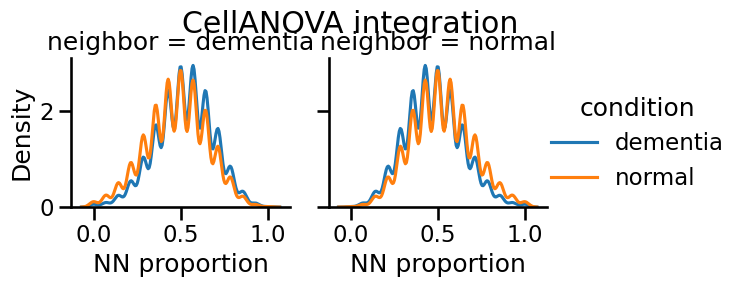

neighbor   dementia    normal
condition                    
dementia   0.520470  0.479530
normal     0.478189  0.521811
Calculating global distortion...


Finish
Evaluate gene-level signal distortion


Finish
Plot of main effect:


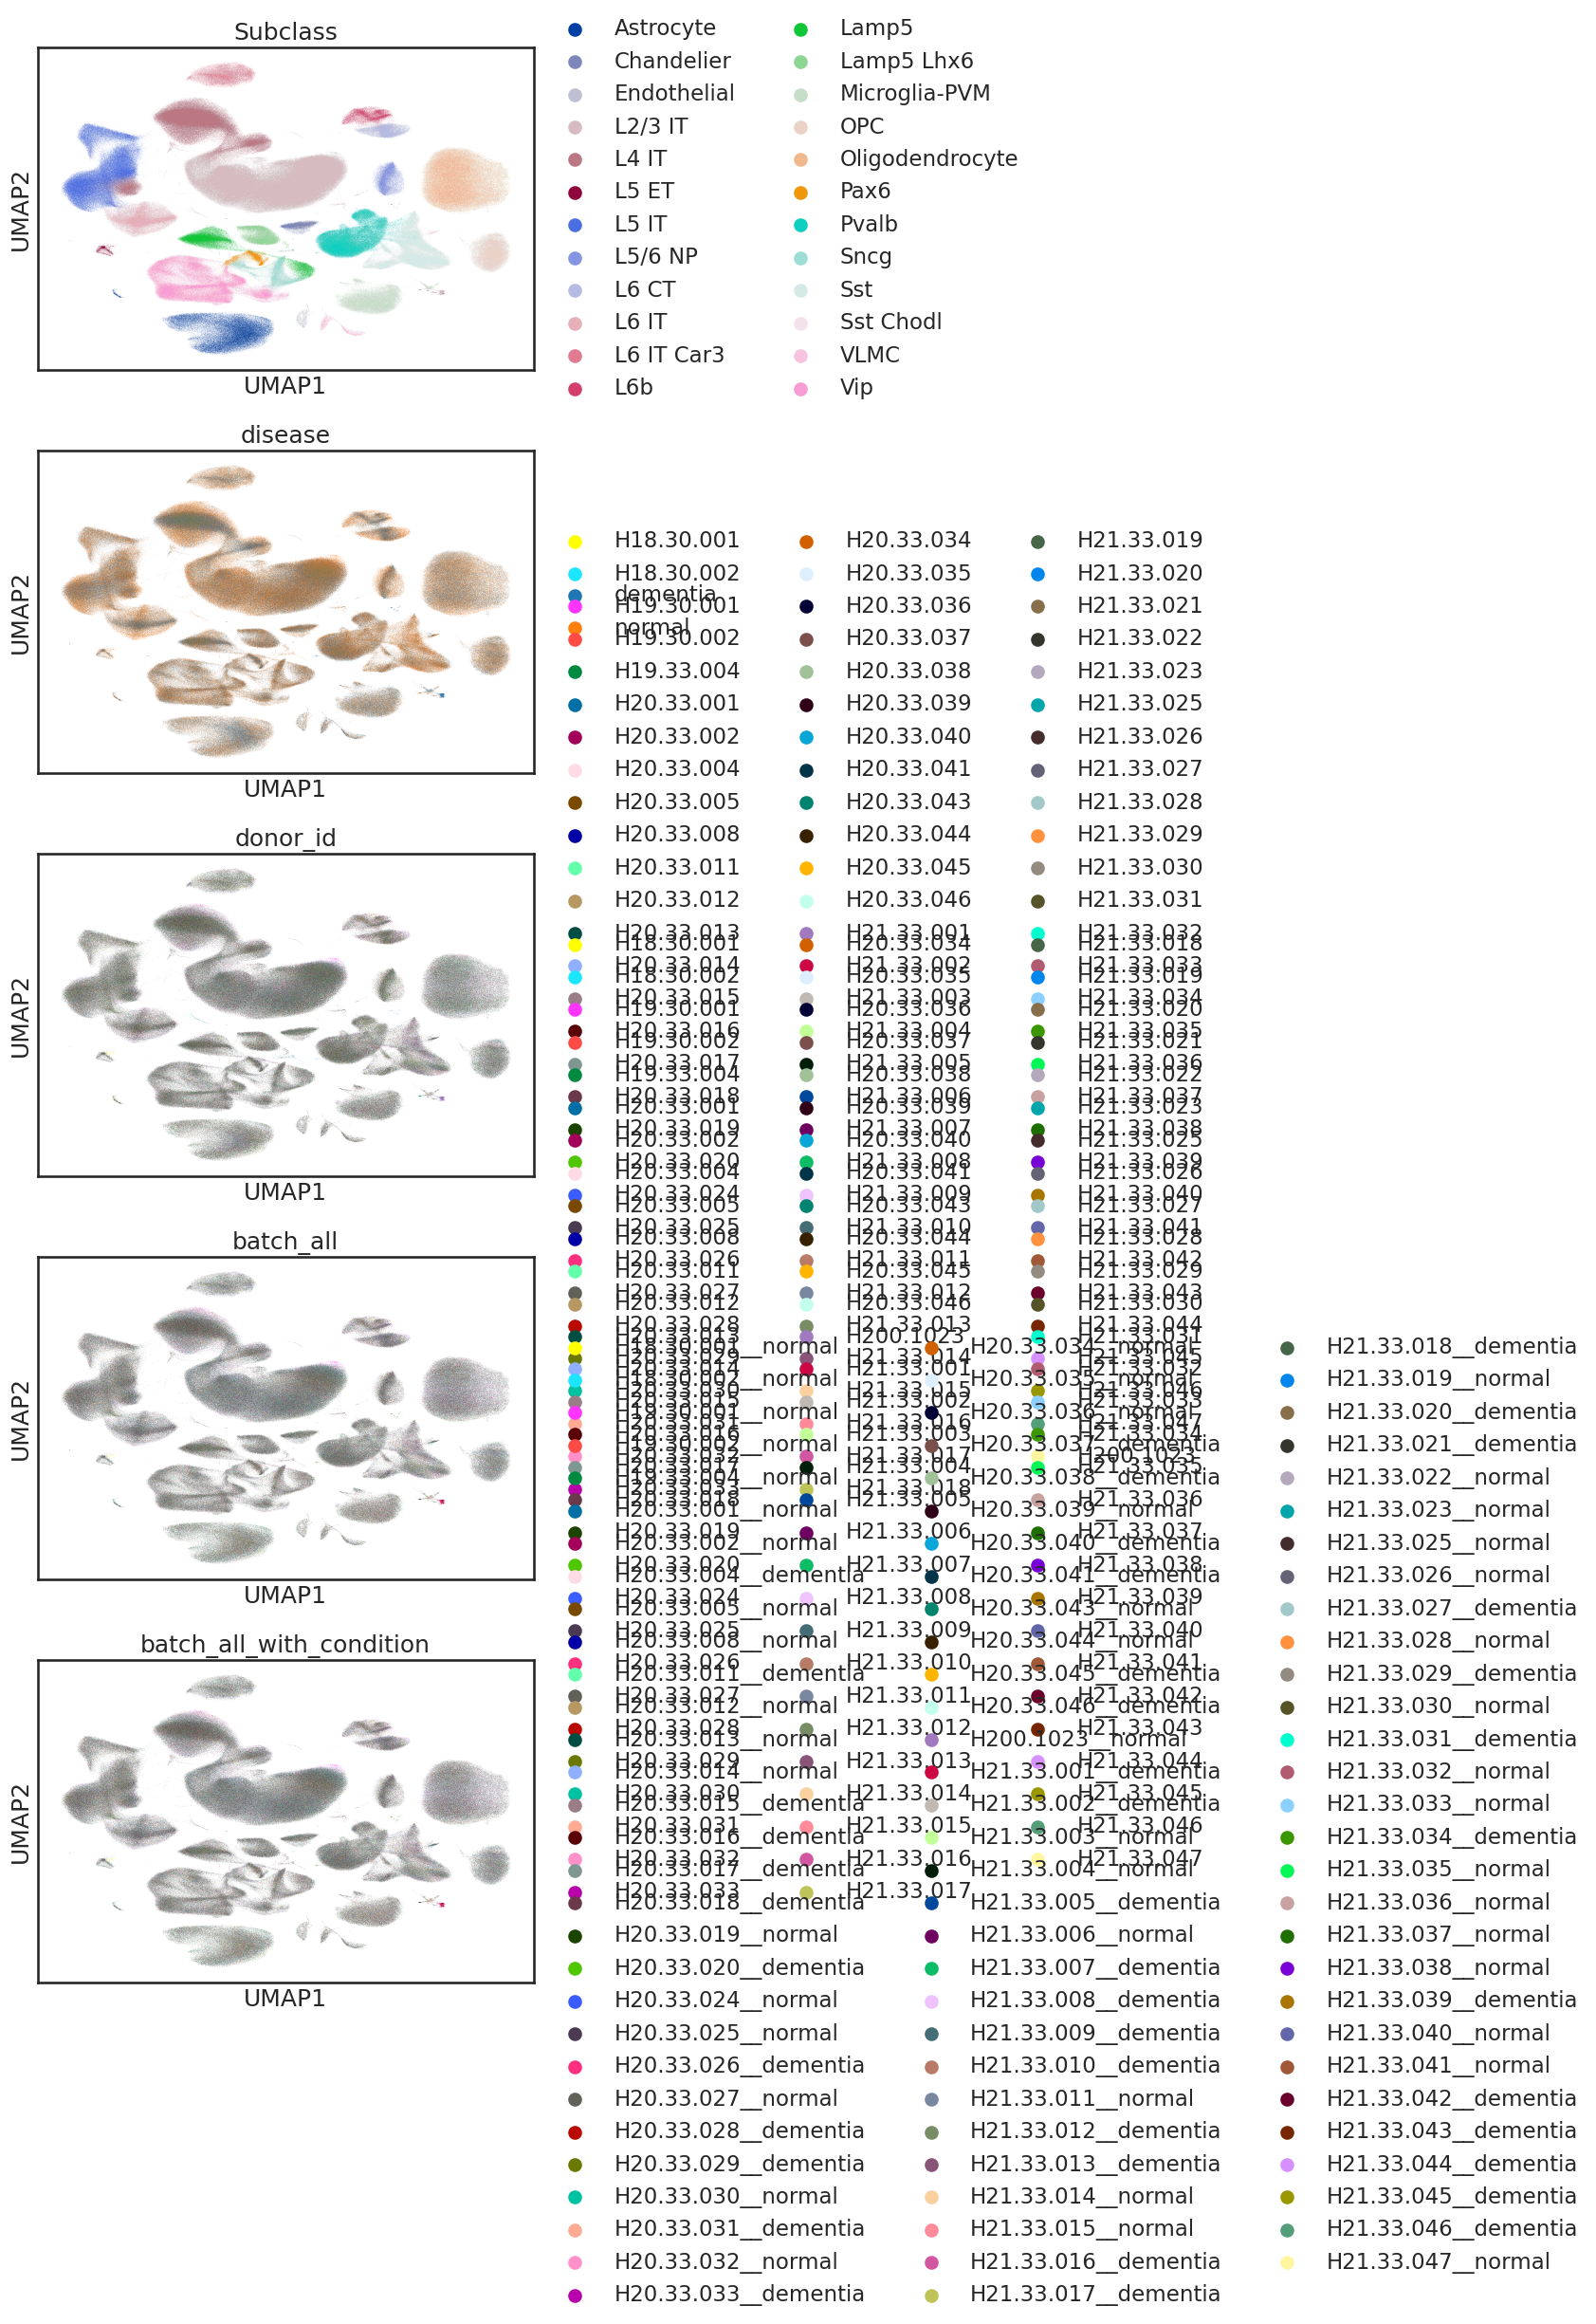

Plot of denoised expression


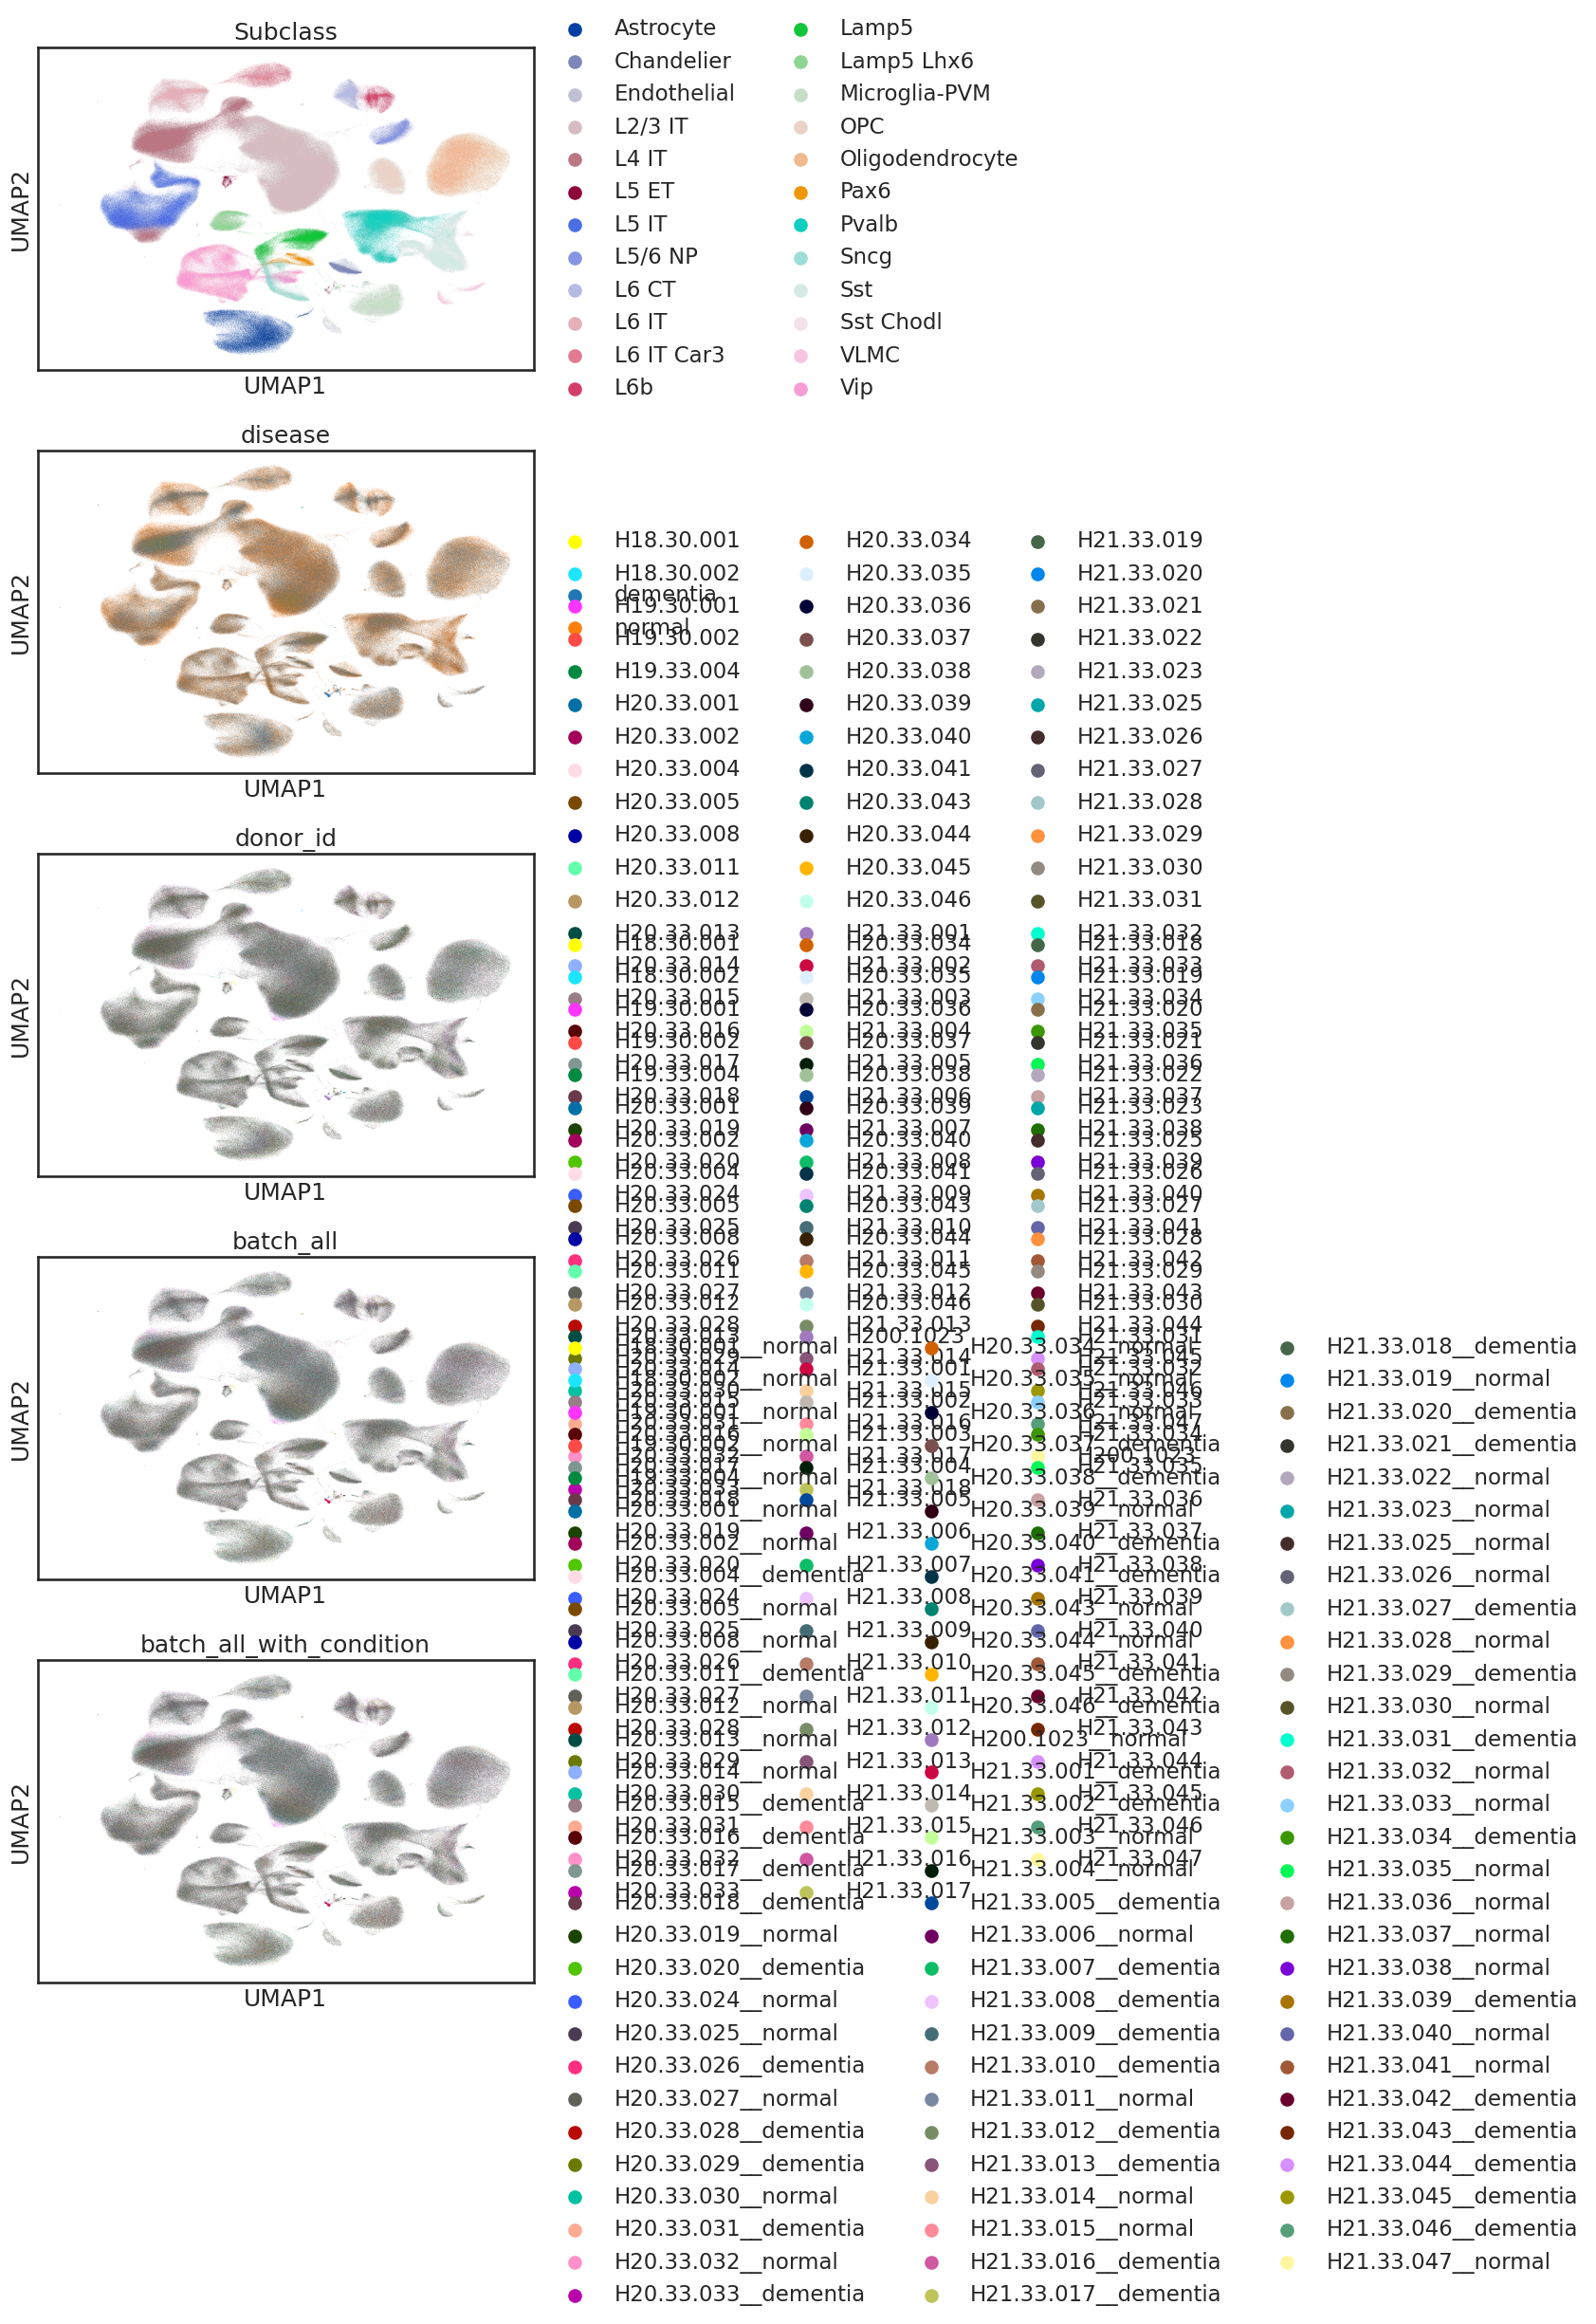

Finish adata preprocessing ====================
Batch effect:
Within each unique condition, evaluate the batch effect


Now evaluating dementia


['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9986680231373625 0.16616097345925745 0.2849167583773694


ASW---


asw_label 0.6564133763313293


asw_batch 0.8675552757041824


kBET---


graph_conn 0.9954034530905315


NMI, ARI ---


NMI 0.9155091479256188
ARI 0.8533744151832223
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.656413  0.853374  0.915509  0.998668  0.166161   0.867555   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca                 0            0.995403        0.0  0.985362   

       true pos rate   F1 LISI  
X_pca       0.125402  0.284917  


********************
Now evaluating normal


['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9988537043335509 0.15848741259371477 0.2735679858670756


ASW---


asw_label 0.6500412374734879


asw_batch 0.8680005984754944


kBET---


graph_conn 0.9978829880210887


NMI, ARI ---


NMI 0.9338393545602732
ARI 0.913634901084524
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.650041  0.913635  0.933839  0.998854  0.158487   0.868001   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca                 0            0.997883        0.0  0.988516   

       true pos rate   F1 LISI  
X_pca        0.08526  0.273568  


********************
Batch-related mixing performance evaluation for main effect:
batch_all_with_condition
['/gpfs/gibbs/project/wang_zuoheng/xx244/R/4.3'
 '/vast/palmer/apps/avx2/software/R/4.3.2-foss-2022b-patched/lib64/R/library']


LISI---


cLISI, bLISI, LISI_F1 0.9988478014553488 0.09746936363889973 0.177607471048941


ASW---


asw_label 0.6536616086959839


asw_batch 0.8362383264347142


kBET---


graph_conn 0.9973451560243479


NMI, ARI ---


NMI 0.9179611723923806
ARI 0.885055409256923
positive and true positive rate---


       ASW_label       ARI       NMI   1-cLISI     bLISI  ASW_batch  \
X_pca   0.653662  0.885055  0.917961  0.998848  0.097469   0.836238   

       kBET Accept Rate  graph connectivity  PCR_batch  pos rate  \
X_pca                 0            0.997345        0.0   0.98768   

       true pos rate   F1 LISI  
X_pca       0.031666  0.177607  


In [3]:
adata=sc.read_h5ad("./cellanova/AD_results.h5ad")
adata.raw=None
print(adata.obs_names)
evaluate_cellanova(adata=adata,cell_type_key='Subclass',batch_key=['donor_id'],
                   condition_key="disease",dataset_name="AD")